In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt

In [2]:
import numpy as np

# 데이터 로딩

In [3]:
trainset_raw = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
testset_raw = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)

In [4]:
def preprocess_cifar(dataset):
    images = torch.tensor(np.transpose(np.array(dataset.data), (0,3,1,2)), dtype=torch.float32) / 255.0
    mean = images.mean([0,2,3], keepdim=True)
    std = images.std([0,2,3], keepdim=True)
    images = (images - mean) / std
    labels = torch.tensor(dataset.targets)
    return images, labels

In [5]:
train_images, train_labels = preprocess_cifar(trainset_raw)
test_images, test_labels = preprocess_cifar(testset_raw)

In [6]:
# train/val split
train_size = int(0.8 * len(train_images))
val_size = len(train_images) - train_size

In [7]:
train_images, val_images = torch.utils.data.random_split(train_images, [train_size, val_size])
train_labels, val_labels = torch.utils.data.random_split(train_labels, [train_size, val_size])

In [8]:
trainloader = torch.utils.data.DataLoader(list(zip(train_images, train_labels)), batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(list(zip(val_images, val_labels)), batch_size=64, shuffle=False)

# 모델 생성

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = self.relu(self.fc1(x))
        return self.fc2(x)

In [11]:
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 학습

In [12]:
train_losses, val_losses, val_accuracies = [], [], []

In [13]:
for epoch in range(20):
    model.train()
    running_loss = 0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(trainloader))

    # ----- Validation -----
    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for images, labels in valloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_losses.append(val_loss / len(valloader))
    val_accuracies.append(100 * correct / total)

    print(f"Epoch [{epoch+1}/20], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.2f}%")


Epoch [1/20], Train Loss: 2.3036, Val Loss: 2.3027, Val Acc: 10.16%
Epoch [2/20], Train Loss: 2.3029, Val Loss: 2.3029, Val Acc: 9.72%
Epoch [3/20], Train Loss: 2.3030, Val Loss: 2.3026, Val Acc: 10.34%
Epoch [4/20], Train Loss: 2.3024, Val Loss: 2.3033, Val Acc: 9.47%
Epoch [5/20], Train Loss: 2.3007, Val Loss: 2.3057, Val Acc: 9.67%
Epoch [6/20], Train Loss: 2.2959, Val Loss: 2.3082, Val Acc: 9.39%
Epoch [7/20], Train Loss: 2.2801, Val Loss: 2.3275, Val Acc: 9.88%
Epoch [8/20], Train Loss: 2.2399, Val Loss: 2.3577, Val Acc: 9.55%
Epoch [9/20], Train Loss: 2.1560, Val Loss: 2.4375, Val Acc: 9.76%
Epoch [10/20], Train Loss: 2.0089, Val Loss: 2.5680, Val Acc: 10.27%
Epoch [11/20], Train Loss: 1.8052, Val Loss: 2.8289, Val Acc: 10.11%
Epoch [12/20], Train Loss: 1.5760, Val Loss: 3.1467, Val Acc: 10.05%
Epoch [13/20], Train Loss: 1.3424, Val Loss: 3.6309, Val Acc: 10.30%
Epoch [14/20], Train Loss: 1.1353, Val Loss: 4.3059, Val Acc: 10.20%
Epoch [15/20], Train Loss: 0.9552, Val Loss: 4.860

# 학습결과 확인

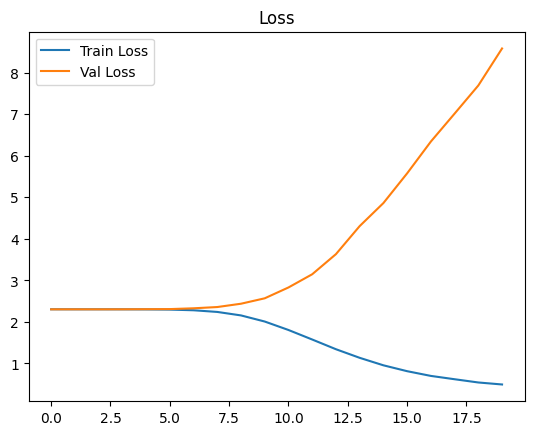

In [14]:
plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.title("Loss")
plt.show()

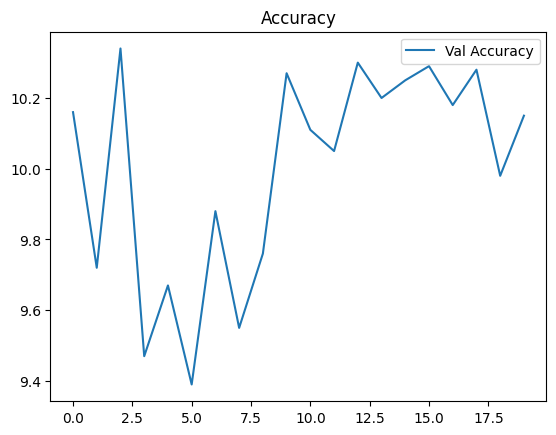

In [15]:
plt.figure()
plt.plot(val_accuracies, label="Val Accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()